In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import glob
import os
import re
import seaborn as sns
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import re
import datetime
from afinn import Afinn
import matplotlib.pyplot as plt
tqdm.pandas()
import scipy as sc

nlp = spacy.load("en_core_web_sm")

## Load the data

In [110]:
# quotes
quotes = pd.read_csv("../data/50moviesquotes.csv.gz")

In [122]:
alttitles = dict([
    ('Star Wars: Episode VII - The Force Awakens', ['Star Wars', 'The force awakens']),
    ('Avengers: Endgame', ['Avengers', 'Endgame']),
    ('Black Panther', ['Black Panther']),
    ('Avengers: Infinity War', ['Infinity War', 'Avengers']),
    ('Jurassic World', ['Jurassic']), # Probably a bad idea but let's see
    ('Star Wars: Episode VIII - The Last Jedi', ['Star Wars', 'Last Jedi']),
    ('Incredibles 2', ['Incredibles']), # Possibly too broad
    ('The Lion King', ['Lion King']),
    ('Rogue One: A Star Wars Story', ['Rogue One', 'Star Wars']),
    ('Star Wars: Episode IX - The Rise of Skywalker', ['Star Wars', 'Skywalker']),
    ('Beauty and the Beast', ['Beauty and the Beast']),
    ('Finding Dory', ['Finding Dory']),
    ('Frozen II', ['Frozen']), # Probably a bad idea but let's see
    ('Avengers: Age of Ultron', ['Avengers', 'Ultron']),
    ('Toy Story 4', ['Toy Story']),
    ('Captain Marvel', ['Marvel']),
    ('Jurassic World: Fallen Kingdom', ['Jurassic', 'Fallen Kingdom']),
    ('Captain America: Civil War', ['Captain America', 'Civil War']),
    ('Jumanji: Welcome to the Jungle', ['Jumanji', 'Welcome to the Jungle']),
    #('Spider-Man: Far from Home', ['Spider-Man', 'Spider Man', 'Far from Home']),
    ('Guardians of the Galaxy Vol. 2', ['Guardians of the Galaxy']),
    ('The Secret Life of Pets', ['Secret Life of Pets']),
    ('The Jungle Book', ['Jungle Book']),
    ('Deadpool', ['Deadpool']),
    ('Inside Out', ['Inside Out']),
    ('Aladdin', ['Aladdin']),
    ('Furious 7', ['Furious']), # Probably a bad idea but let's see
    ('American Sniper', ['American Sniper']),
    ('Zootopia', ['Zootopia']),
    ('The Hunger Games: Mockingjay - Part 1', ['Hunger Games', 'Mockingjay']),
    ('Minions', ['Minions']), # Possibly too broad
    ('Joker', ['Joker']),
    ('Aquaman', ['Aquaman']),
    ('Spider-Man: Homecoming', ['Spider-Man', 'Spider Man', 'Homecoming']),
    ('Batman v Superman: Dawn of Justice', ['Batman', 'Superman', 'Dawn of Justice']),
    #('It', []), # just not possible
    ('Suicide Squad', ['Suicide Squad']),
    ('Jumanji: The Next Level', ['Jumanji', 'The Next Level']),
    ('Deadpool 2', ['Deadpool']),
    ('Thor: Ragnarok', ['Thor', 'Ragnarok']),
    ('The Hunger Games: Mockingjay - Part 2', ['Hunger Games', 'Mockingjay']),
    ('The Grinch', ['Grinch']),
    ('Sing', ['Sing']), # Probably a bad idea but let's see
    ('Despicable Me 3', ['Despicable Me']),
    ('The Hobbit: The Battle of the Five Armies', ['Hobbit', 'Battle of the Five Armies']),
    ('Moana', ['Moana']),
    ('Fantastic Beasts and Where to Find Them', ['Fantastic Beasts']),
    ('Doctor Strange', ['Doctor Strange']),
    ('Justice League', ['Justice League'])
])

In [123]:
# remove title from quotations
for movie in alttitles:
    for strt in alttitles[movie]:
        val = quotes.loc[quotes["primaryTitle"]==movie]["quotation"].str.replace(strt, '',case=False)
        quotes.loc[quotes["primaryTitle"]==movie,"quotation"] = val

In [124]:
# boxoffice see movieBoxOffice.ipynb to generate the dataset
boxoffice = pd.read_csv("../data/boxoffice.csv")
boxoffice["boxoffice"] = boxoffice["Gross"].apply(lambda x:int(x.replace("$","").replace(",","")))
boxoffice["% of Total"] = pd.to_numeric(boxoffice["% of Total"].str.replace("%",""),errors="coerce")

In [125]:
# merge quotes and boxoffice
quotes = pd.merge(left=quotes,right=boxoffice,how="left",left_on="primaryTitle",right_on="Release")
# add a field to count days between quote and release date
quotes["diff_date"] = (pd.to_datetime(quotes["date"]) - pd.to_datetime(quotes["Release Date"])).dt.days
# only keep around a window
DELTA_T = 10
quotes = quotes[(quotes["diff_date"]<DELTA_T)&(quotes["diff_date"]>-DELTA_T)]


## Sentiment polarity

In [126]:
afn = Afinn()

nlp = en_core_web_sm.load()

punctuations = string.punctuation
#stopwords = list(STOP_WORDS)

parser = nlp
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in punctuations ]
    tokens = " ".join([i for i in tokens])
    return tokens

def count_words(s):
    return len(s.split())

def sentiment(s):
    return afn.score(s)

In [127]:
quotes["text_clean"] = quotes["quotation"].apply(spacy_tokenizer)
quotes["text"] = quotes["text_clean"].astype('str')

In [128]:
quotes["sentiment"] = quotes["text"].apply(sentiment)
quotes["word_counts"] = quotes["text"].apply(count_words)

### Plot the results

/Users/goujon/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 5.0)

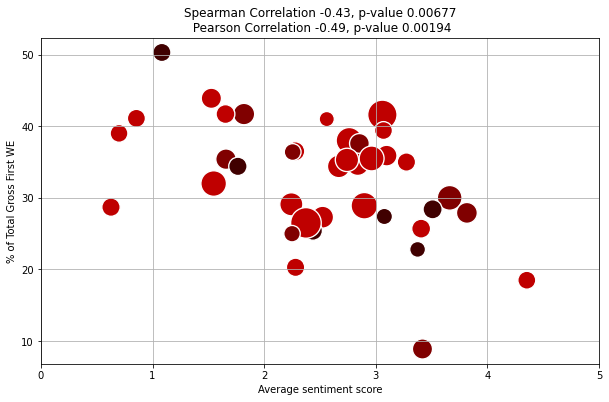

In [245]:
plt.figure(figsize=(10,6))
quotes_gr1 = quotes[(quotes["diff_date"]>-10)&(quotes["diff_date"]<10)&(quotes["primaryTitle"]!="Sing")].groupby("primaryTitle").agg(percent=("% of Total","first"),sentiment=("sentiment","mean"),count=("sentiment","count"),boxoffice=("boxoffice","first")).reset_index()
quotes_gr1 = quotes_gr1[quotes_gr1["count"]>20]
cmap = np.array([(1,0,0),(2,0,0),(3,0,0)])/4
cat = (quotes_gr1["count"]<80)*0+(quotes_gr1["count"]>=80)*1 + (quotes_gr1["count"]>200)*1
sns.scatterplot(quotes_gr1["sentiment"],quotes_gr1["percent"],s=quotes_gr1["boxoffice"]/1e6,c=cmap[cat])
plt.xlabel("Average sentiment score")
plt.ylabel("% of Total Gross First WE")
a1 = sc.stats.spearmanr(quotes_gr1["sentiment"],quotes_gr1["percent"])
b1 = sc.stats.pearsonr(quotes_gr1["sentiment"],quotes_gr1["percent"])
plt.title(f"Spearman Correlation {a1[0]:.2}, p-value {a1[1]:.3}\n Pearson Correlation {b1[0]:.2}, p-value {b1[1]:.3}")
plt.grid()
plt.xlim(0,5)

/Users/goujon/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


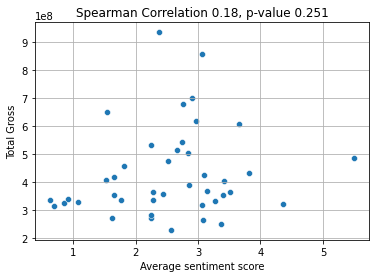

In [235]:
quotes_gr2 = quotes[(quotes["diff_date"]>-100)&(quotes["diff_date"]<100)].groupby("primaryTitle").agg(boxoffice=("boxoffice","first"),sentiment=("sentiment","mean")).reset_index()
sns.scatterplot(quotes_gr2["sentiment"],quotes_gr2["boxoffice"])
plt.xlabel("Average sentiment score")
plt.ylabel("Total Gross")
#spearman correlation
a2 = sc.stats.spearmanr(quotes_gr2["sentiment"],quotes_gr2["boxoffice"])
plt.title(f"Spearman Correlation {a2[0]:.2}, p-value {a2[1]:.3}")
plt.grid()